In [3]:
!pip install emoji

  Using cached emoji-2.12.1-py3-none-any.whl (431 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acceso denegado: 'c:\\programdata\\anaconda3\\lib\\site-packages\\__pycache__\\typing_extensions.cpython-38.pyc'
Consider using the `--user` option or check the permissions.



In [4]:
import plotly.graph_objs as go
import pandas as pd
import re
import sys
import regex
import emoji
import json
import os
import numpy as np
from collections import Counter
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime

ModuleNotFoundError: No module named 'plotly'

### Paso 1: Definir funciones necesarias

In [ ]:
# Obtener los patrones de los números telefónicos de países
phone_patterns = [line.strip().split(';')[1] + ":" for line in open('Data/phone_patterns.txt', 'r')]
print(phone_patterns)

In [5]:
# Patron regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    # Ejemplo: '9/16/23, 5:59 PM - ...'
    patron = r'^(\d{1,2})\/(\d{1,2})\/(\d{4}),\s*(\d{1,2}):(\d{2})\s*(a\.?\s*m\.?|p\.?\s*m\.?)\s*-'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    if resultado:
        return True
    return False

# Patrón para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = [
        '([\w]+):',                                # Nombre
        '([\w]+[\s]+[\w]+):',                      # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',            # Nombre 1 + Nombre 2 + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+):',  # Nombre 1 + Nombre 2+ Nombre 3 + Apellido
        '([\w]+[\s])[\u263a-\U0001f999]+:',        # Nombre + Emoji
    ]
    patrones+=phone_patterns # Se añade los patrones de los números telefónicos

    patron = '^' + '|'.join(patrones)
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    # Ejemplo: '9/16/23, 5:59 PM - Sandreke: Todos debemos aprender a analizar datos'
    splitLinea = linea.split(' - ')
    FechaHora = splitLinea[0]                     # '9/16/23, 5:59 PM'
    splitFechaHora = FechaHora.split(', ')
    Fecha = splitFechaHora[0]                    # '9/16/23'
    Hora = ' '.join(splitFechaHora[1:])          # '5:59 PM'
    Mensaje = ' '.join(splitLinea[1:])             # 'Sandreke: Todos debemos aprender a analizar datos'
    if EncontrarMiembro(Mensaje):
        splitMensaje = Mensaje.split(': ')
        Miembro = splitMensaje[0]               # 'Sandreke'
        Mensaje = ' '.join(splitMensaje[1:])    # 'Todos debemos aprender a analizar datos'
    else:
        Miembro = None       
    return Fecha, Hora, Miembro, Mensaje

### Paso 2: Obtener el dataframe usando el archivo txt y las funciones definidas

In [6]:
# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = 'Data/chatConBel.txt'
# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline()
        if not linea:
            break
        linea = linea.strip()
        if IniciaConFechaYHora(linea):
            # Si cada línea del txt coincide con el patrón fecha y hora
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            DatosLista.append([Fecha, Hora, Miembro, Mensaje])
# Convertir la lista con los datos a dataframe
pd.set_option('display.max_columns', None)
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])
df = df.dropna()
# Resetear el índice
df.reset_index(drop=True, inplace=True)
print(df['Hora'])

NameError: name 're' is not defined

#### Filtrar el chat por fecha de acuerdo a lo requerido

In [17]:
start_date = '2023-06-01'
end_date = '2023-09-30'

df = df[(df['Fecha'] >= start_date) & (df['Fecha'] <= end_date)]
print(df)

Empty DataFrame
Columns: [Fecha, Hora, Miembro, Mensaje]
Index: []


### Paso 3: Estadísticas de mensajes, multimedia, emojis y links

#### Total de mensajes, multimedia, emojis y links enviados

In [5]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje) # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if caracter in emoji.EMOJI_DATA: # Obtener emojis en idioma español
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Media omitted>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

# Obtener la cantidad de encuestas
encuestas = df[df['Mensaje'] == 'POLL:'].shape[0]

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links', 'Encuestas'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, encuestas]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,39998
Multimedia,0
Emojis,12841
Links,101
Encuestas,0


#### Emojis más usados

In [6]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df.head(10)

Número emojis únicos usados:  87 



,Cantidad
Emoji,
❤️,5000
🥹,3477
🫂,1071
❤‍🩹,911
😆,447
😭,261
🫶🏻,217
🤤,188
🫠,186


In [7]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Paso 4: Estadísticas de los miembros del grupo

#### Miembros más activos

In [9]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos

,Miembro,Mensaje
1,Jose,20231
2,Bel,19767


#### Estadísticas por miembro

In [10]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Media omitted>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,Letras,Palabras
39993,14/2/2024,10:56 a. m.,Bel,ya hable con el otro,[],0,20,5
39994,14/2/2024,10:56 a. m.,Bel,doc,[],0,3,1
39995,14/2/2024,10:56 a. m.,Bel,ahora te cuento q me dijo amor,[],0,30,7
39996,14/2/2024,11:08 a. m.,Jose,Está bien amor mío,[],0,18,4
39997,14/2/2024,11:08 a. m.,Jose,Te amo ❤️🫂,"[❤️, 🫂]",0,10,3


In [11]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
    lista = []
    # Filtrar mensajes de un miembro en específico
    miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

    # Agregar a la lista el número total de mensajes enviados
    lista.append(miembro_df.shape[0])
    
    # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
    palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
    lista.append(palabras_por_msj)

    # Agregar a la lista el número de mensajes multimedia enviados
    multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
    lista.append(multimedia)

    # Agregar a la lista el número total de emojis enviados
    emojis = sum(miembro_df['Emojis'].str.len())
    lista.append(emojis)

    # Agregar a la lista el número total de links enviados
    links = sum(miembro_df['URLs'])
    lista.append(links)

    # Asignar la lista como valor a la llave del diccionario
    dictionario[miembros[i]] = lista
    
print(dictionario)

{'Bel': [19767, 4.139323114281378, 0, 5905, 51], 'Jose': [20231, 4.881221887202807, 0, 6936, 50]}


In [13]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Jose,20231,4.881222,0,6936,50
Bel,19767,4.139323,0,5905,51


In [39]:
print(df)

            Fecha         Hora Miembro  \
0      11/11/2023   1:21 p. m.     Bel   
1      11/11/2023   1:21 p. m.    Jose   
2      11/11/2023   1:21 p. m.    Jose   
3      11/11/2023   1:21 p. m.    Jose   
4      11/11/2023   1:21 p. m.    Jose   
...           ...          ...     ...   
39993   14/2/2024  10:56 a. m.     Bel   
39994   14/2/2024  10:56 a. m.     Bel   
39995   14/2/2024  10:56 a. m.     Bel   
39996   14/2/2024  11:08 a. m.    Jose   
39997   14/2/2024  11:08 a. m.    Jose   

                                                 Mensaje   Emojis  URLs  \
0      Decía que no me bota un resumen como tal solo ...       []     0   
1                                               Claro tú       []     0   
2                                                  Dilee       []     0   
3                            Por favor hazme un resumend       []     0   
4                                Y te los va a dar corto       []     0   
...                                          

### Paso 5: Estadísticas del comportamiento del grupo

In [59]:
# Function to replace narrow non-breaking spaces and parse the time
def preprocess_time(time_str):
    # Further clean up the string by removing additional spaces around 'a.' and 'p.'
    time_str = time_str.replace('\u202F', ' ')
    time_str = time_str.replace('a. m.', 'AM').replace('p. m.', 'PM')
    # Parse the time string into a datetime object
    return datetime.strptime(time_str, "%I:%M %p")


df['HoraParseadaRango'] = df['Hora'].apply(preprocess_time)
df['HoraParseada'] = df['HoraParseadaRango'].dt.strftime('%H:%M')
print(df['HoraParseadaRango'])
print(df['HoraParseada'])
#df['rangoHora'] = pd.to_datetime(df['HoraParseadaRango'], format='%I:%M %p')# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# # # Apply the function to create the "Range Hour" column
df['rangoHora'] = df['HoraParseadaRango'].apply(lambda x: f'{x.hour:02d} - {(x + pd.Timedelta(hours=1)).hour:02d} h')
print(df['rangoHora'])

0       1900-01-01 13:21:00
1       1900-01-01 13:21:00
2       1900-01-01 13:21:00
3       1900-01-01 13:21:00
4       1900-01-01 13:21:00
                ...        
39993   1900-01-01 10:56:00
39994   1900-01-01 10:56:00
39995   1900-01-01 10:56:00
39996   1900-01-01 11:08:00
39997   1900-01-01 11:08:00
Name: HoraParseadaRango, Length: 39998, dtype: datetime64[ns]
0        13:21
1        13:21
2        13:21
3        13:21
4        13:21
         ...  
39993    10:56
39994    10:56
39995    10:56
39996    11:08
39997    11:08
Name: HoraParseada, Length: 39998, dtype: object
0        13 - 14 h
1        13 - 14 h
2        13 - 14 h
3        13 - 14 h
4        13 - 14 h
           ...    
39993    10 - 11 h
39994    10 - 11 h
39995    10 - 11 h
39996    11 - 12 h
39997    11 - 12 h
Name: rangoHora, Length: 39998, dtype: object


In [60]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por rango de hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
#date_df = df.groupby('rangoHora').sum()
#date_df.reset_index(inplace=True)

date_df = df.groupby('rangoHora')['# Mensajes por rango de hora'].count().reset_index()


# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='rangoHora', y='# Mensajes por rango de hora')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=12))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

#### Número de mensajes por rango de hora

In [61]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes en esta hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
#date_df = df.groupby('rangoHora').sum()
#date_df.reset_index(inplace=True)

date_df = df.groupby('HoraParseada')['# Mensajes en esta hora'].count().reset_index()


# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='HoraParseada', y='# Mensajes en esta hora')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=12))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

In [62]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')
print(df['Fecha'])

0       2023-11-11
1       2023-11-11
2       2023-11-11
3       2023-11-11
4       2023-11-11
           ...    
39993   2024-02-14
39994   2024-02-14
39995   2024-02-14
39996   2024-02-14
39997   2024-02-14
Name: Fecha, Length: 39998, dtype: datetime64[ns]


In [65]:
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha')['# Mensajes por día'].sum().reset_index()
date_df.sort_values(by='Fecha', inplace=True)
print(date_df)

        Fecha  # Mensajes por día
0  2023-11-11                 263
1  2023-11-12                 244
2  2023-11-13                 542
3  2023-11-14                 363
4  2023-11-15                 766
..        ...                 ...
80 2024-02-10                  28
81 2024-02-11                 125
82 2024-02-12                 301
83 2024-02-13                 262
84 2024-02-14                 260

[85 rows x 2 columns]


#### Número de mensajes a través del tiempo

In [66]:
#Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=17))
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

#### Word Cloud de palabras más usadas por el grupo

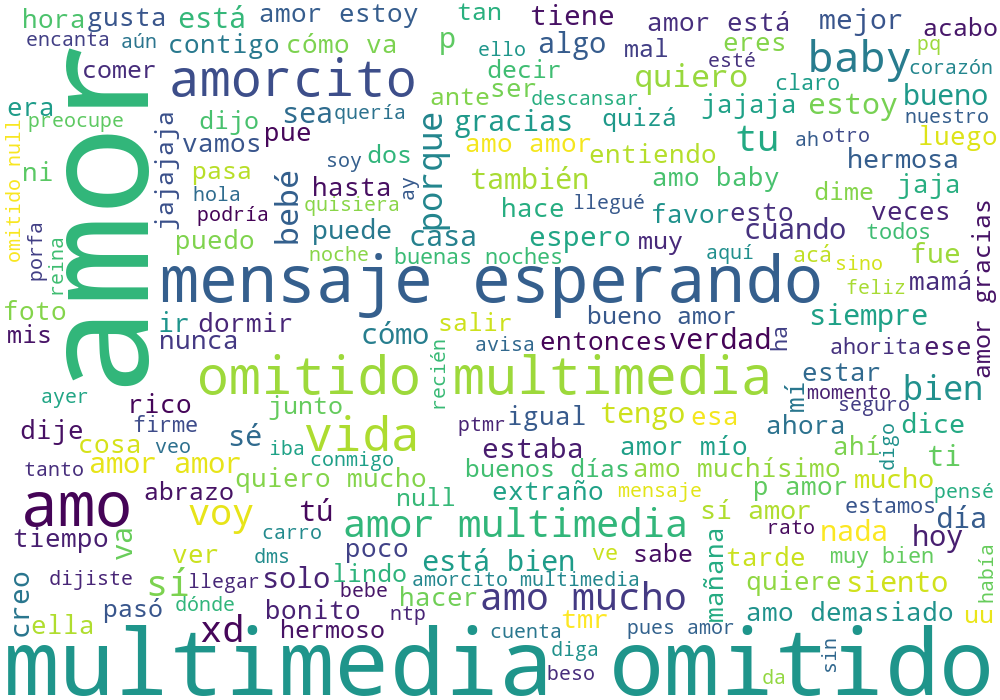

In [46]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Media','omitted',
                              'y', 'mi', 'o', 'q', 'yo', 'al'])

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 1000, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()